In [130]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import time

In [131]:
# GPU desteği var mı kontrol et
if torch.backends.mps.is_available():
    device = torch.device("mps")  # Apple Metal GPU backend
    print("MPS (GPU) kullanılacak.")
else:
    device = torch.device("cpu")
    print("GPU desteklenmiyor, CPU kullanılacak.")

MPS (GPU) kullanılacak.


In [132]:
def read_images(path, num_img):
    array = np.zeros((num_img, 64*32))
    i = 0
    for img in os.listdir(path):
        img_path = path + '/' + img
        img = Image.open(img_path, mode= 'r')
        data = np.asanyarray(img, dtype= 'uint8') # Image to array with unit8 format
        data = data.flatten()
        array[i,:] = data
        i += 1
    return array

<h3>Negatives

In [133]:
train_negative_path = r'Data/LSIFIR/Classification/Train/neg'
num_train_negative_img = 43390

In [134]:
train_negative_array = read_images(train_negative_path, num_train_negative_img)

In [135]:
x_train_negative_tensor = torch.from_numpy(train_negative_array)

In [136]:
y_train_negative_tensor = torch.zeros(num_train_negative_img, dtype= torch.long)

<h3>Positives

In [137]:
train_positive_path = r'Data/LSIFIR/Classification/Train/pos'
num_train_positive_img = 10208

In [138]:
train_positive_array = read_images(train_positive_path, num_train_positive_img)

In [139]:
x_train_positive_tensor = torch.from_numpy(train_positive_array)

In [140]:
y_train_positive_tensor = torch.ones(num_train_positive_img, dtype= torch.long)

<h3>Concat Train

In [141]:
x_train = torch.cat((x_train_negative_tensor,x_train_positive_tensor),0)
y_train = torch.cat((y_train_negative_tensor,y_train_positive_tensor),0)

In [142]:
print("x_train: ",x_train.size())
print("y_train: ",y_train.size())

x_train:  torch.Size([53598, 2048])
y_train:  torch.Size([53598])


<h3>Test Negative

In [143]:
test_negative_path = r'Data/LSIFIR/Classification/Test/neg'
num_test_negative_img = 22050

In [144]:
test_negative_array = read_images(test_negative_path,num_test_negative_img)

In [145]:
x_test_negative_tensor = torch.tensor(test_negative_array[:20855,:])
y_test_negative_tensor = torch.zeros(20855, dtype= torch.long)

<h3>Test Positive

In [146]:
test_positive_path = r'Data/LSIFIR/Classification/Test/pos'
num_test_positive_img = 5944

In [147]:
test_positive_array = read_images(test_positive_path,num_test_positive_img)

In [148]:
x_test_positive_tensor = torch.tensor(test_positive_array)
y_test_positive_tensor = torch.ones(num_test_positive_img, dtype=torch.long)

<h3>Concat Test

In [149]:
x_test = torch.cat((x_test_negative_tensor, x_test_positive_tensor), 0)
y_test = torch.cat((y_test_negative_tensor, y_test_positive_tensor), 0)

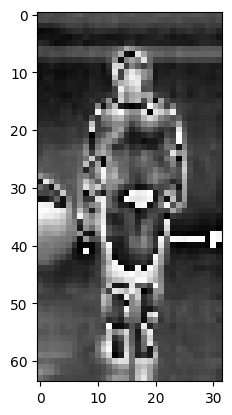

In [150]:
plt.imshow(x_train[49001,:].reshape(64,32,), cmap='gray')

In [151]:
#Hyperparameter
num_epochs = 5000
num_classes = 2
batch_size = 8933
learning_rate = 0.00001

In [152]:
train = torch.utils.data.TensorDataset(x_train, y_train) # Train verilerimizi Troch için uygun formata getirme
trainloader = torch.utils.data.DataLoader(train,batch_size= batch_size, shuffle=True ) # Uygun formata getirilmiş train setimizi hyperparametreler ile initialize etme

test = torch.utils.data.TensorDataset(x_train, y_train) # Test verilerimizi Troch için uygun formata getirme
testloader = torch.utils.data.DataLoader(test,batch_size= batch_size, shuffle=False ) # Uygun formata getirilmiş train setimizi hyperparametreler ile initialize etme

<h1 style="color:aqua;"> -------- ResNet --------

In [153]:
def conv3x3(in_planes, out_planes, stride= 1):
    return nn.Conv2d(in_planes,out_planes, kernel_size= 3, stride= stride, padding= 1, bias= False)

def conv1x1(in_planes, out_planes, stride= 1):
    return nn.Conv2d(in_planes,out_planes, kernel_size= 1, stride= stride, bias= False)

In [154]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self,inplanes, planes, stride= 1, downsample= None):
        super(BasicBlock,self).__init__()

        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace= True) # inplace = Reluyu çağırdıktan sonra sonucu kendisine eşitleme
        self.drop = nn.Dropout(0.6)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self,x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.drop(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.drop(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        if out.shape != identity.shape:
            identity = nn.functional.adaptive_avg_pool2d(identity, out.shape[2:])

        out = out + identity  # ResNet için shortcut yaptığımız yer
        out = self.relu(out)

        return out


In [155]:
class ResNet(nn.Module):
    def __init__(self,block, layers, num_classes= num_classes):
        super(ResNet,self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(1, 64, kernel_size= 7, stride= 2, padding= 3, bias= False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace= True)
        self.maxpool = nn.MaxPool2d(kernel_size= 3, stride= 2, padding= 1)

        self.layer1 = self._make_layer(block, 64, layers[0],stride= 1)
        self.layer2 = self._make_layer(block, 128, layers[1],stride= 2)
        self.layer3 = self._make_layer(block, 256, layers[2],stride= 2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(256*block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m,nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode = "fan_out", nonlinearity= "relu")
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight,1) # tüm weight'leri 1'e eşitle
                nn.init.constant_(m.bias,0) # tüm bias'leri sıfırla

    def _make_layer(self, block, planes, blocks_num, stride= 1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes*block.expansion, stride),
                nn.BatchNorm2d(planes*block.expansion)
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes*block.expansion
        for _ in range(1,blocks_num):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1) # Flatten
        x = self.fc(x)

        return x

In [156]:
model = ResNet(BasicBlock, [2,2,2],num_classes=2).to(device)

In [157]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate, weight_decay=1e-4)

<h2>Train

In [158]:
loss_list = []
train_acc = []
test_acc = []
use_gpu = True

total_step = len(trainloader)

In [159]:
best_acc = 0

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader):
        images = images.view(batch_size,1,64,32)
        images = images.float()

        if use_gpu:
            images, labels = images.to(device), labels.to(device)

        outputs = model(images)

        loss = criterion(outputs, labels)

        #backward and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i%2 == 0:
          print(f"epoch: {epoch} {i}/{total_step}")
    #train
    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
          images, labels = data
          images = images.view(batch_size,1,64,32)
          images = images.float()

          if use_gpu:
            images, labels = images.to(device), labels.to(device)

          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

    print("Accuracy Train %d %%"%(100*correct/total))
    train_acc.append(100*correct/total)

    #test
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
          images, labels = data
          images = images.view(batch_size,1,64,32)
          images = images.float()

          if use_gpu:
            images, labels = images.to(device), labels.to(device)

          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

    print("Accuracy test %d %%"%(100*correct/total))
    test_acc.append(100*correct/total)

    loss_list.append(loss.item())

    if test_acc[-1] > best_acc:
      best_acc = test_acc[-1]
      torch.save(model.state_dict(), 'best_resnet_mac.pth')
      print(f"Yeni en iyi model kaydedildi! Test accuracy: {best_acc:.2f}%")


epoch: 0 0/6
epoch: 0 2/6
epoch: 0 4/6
Accuracy Train 41 %
Accuracy test 41 %
Yeni en iyi model kaydedildi! Test accuracy: 41.25%
epoch: 1 0/6
epoch: 1 2/6
epoch: 1 4/6
Accuracy Train 43 %
Accuracy test 43 %
Yeni en iyi model kaydedildi! Test accuracy: 43.35%
epoch: 2 0/6
epoch: 2 2/6
epoch: 2 4/6
Accuracy Train 45 %
Accuracy test 45 %
Yeni en iyi model kaydedildi! Test accuracy: 45.23%
epoch: 3 0/6
epoch: 3 2/6


KeyboardInterrupt: 

In [160]:
model.load_state_dict(torch.load('best_resnet4.pth',map_location=torch.device(device)))

/var/folders/n8/s31rrs_j13l45k2k_6kxm44w0000gn/T/ipykernel_34951/52847382.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_resnet4.

<All keys matched successfully>

In [161]:
model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (drop): Dropout(p=0.6, inplace=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [162]:
from PIL import Image
import torchvision.transforms as transforms

In [170]:
# prompt: write predict code for this model (with image read part)

import torch
from PIL import Image
import numpy as np

# Assuming 'model' and other necessary variables are defined as in the previous code

def predict_image(image_path):
    img = Image.open(image_path, mode='r')
    data = np.asanyarray(img, dtype='uint8')
    data = data.flatten()
    image_tensor = torch.from_numpy(data).float()
    image_tensor = image_tensor.view(1, 1, 64, 32).to(device)  # Add batch dimension and move to device

    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output.data, 1)

    return predicted.item()


# Example usage:
image_path = "Data/LSIFIR/Classification/Test/neg/00040.png" # Replace with your image path
prediction = predict_image(image_path)
print(f"Prediction for {image_path}: {prediction}") # 0 for negative, 1 for positive


Prediction for Data/LSIFIR/Classification/Test/neg/00040.png: 0


tensor([[[[0.7608, 0.8196, 0.7059,  ..., 0.3176, 0.1961, 0.0941],
          [0.8196, 0.8000, 0.8039,  ..., 0.1333, 0.8157, 0.7608],
          [0.9490, 0.8706, 0.8196,  ..., 0.2863, 0.1412, 0.0784],
          ...,
          [0.4549, 0.3373, 0.2314,  ..., 0.4431, 0.5020, 0.4275],
          [0.5020, 0.3451, 0.3725,  ..., 0.4471, 0.4275, 0.4784],
          [0.5216, 0.4431, 0.5412,  ..., 0.5333, 0.5608, 0.4706]]]],
       device='mps:0')

: 

In [ ]:
with torch.no_grad():
    output = model(img_tensor)
    _, predicted = torch.max(output.data, 1)

print(f"Tahmin edilen sınıf: {predicted.item()}")

Tahmin edilen sınıf: 0


: 

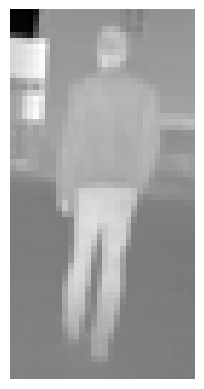

In [219]:
img = Image.open("Data/LSIFIR/Classification/Train/pos/00013.png").resize((32,64))

plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

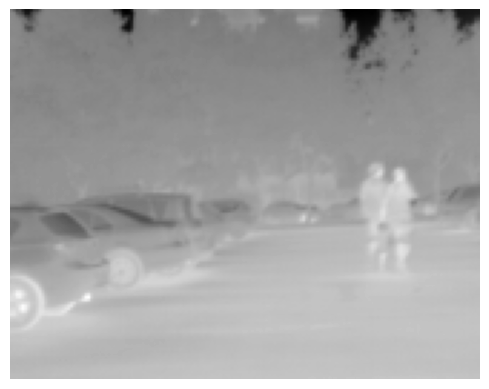

In [228]:
img = Image.open("Data/LSIFIR/Detection/Test/01/00002.png")

plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

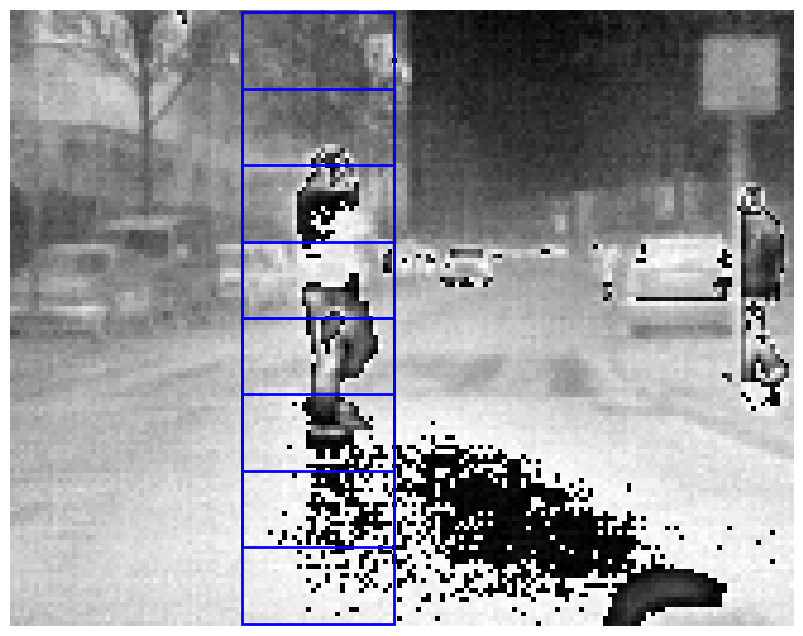

In [202]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch

def predict_window(window):
    data = window.flatten()
    image_tensor = torch.from_numpy(data).float()
    image_tensor = image_tensor.view(1, 1, 64, 32).to(device)

    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output.data, 1)

    return predicted.item()

# --- 1. Büyük resmi oku ---
image_path = "Data/LSIFIR/Detection/Test/04/00008.png"
big_image = Image.open(image_path, mode='r')
big_image_np = np.asarray(big_image, dtype='uint8')

height, width = big_image_np.shape

# --- 2. Plot oluştur ---
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.imshow(big_image_np, cmap='gray', vmin=0, vmax=255)  # Tonları sabitle!

# --- 3. Sliding window ayarları ---
window_height = 64
window_width = 32
step_size = 16

# --- 4. Sliding window ---
for y in range(0, height - window_height + 1, step_size):
    for x in range(0, width - window_width + 1, step_size):
        window = big_image_np[y:y + window_height, x:x + window_width]

        if window.shape != (64, 32):
            continue

        prediction = predict_window(window)

        if prediction == 1:
            rect = patches.Rectangle(
                (x, y),
                window_width,
                window_height,
                linewidth=2,
                edgecolor='blue',
                facecolor='none'
            )
            ax.add_patch(rect)

plt.axis('off')
plt.show()


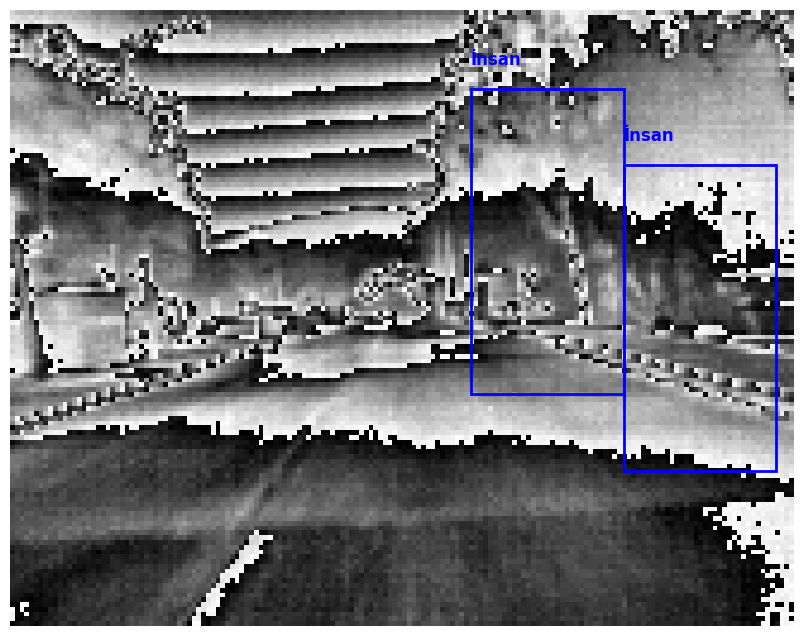

Sonuç kaydedildi: output/00001.png


In [243]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch

# --- 1. Pencereyi modele verip tahmin dönen fonksiyon ---
def predict_window(window):
    data = window.flatten()
    image_tensor = torch.from_numpy(data).float()
    image_tensor = image_tensor.view(1, 1, 64, 32).to(device)

    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output.data, 1)

    return predicted.item()

# --- 2. Non-Maximum Suppression fonksiyonu ---
def non_max_suppression_fast(boxes, overlapThresh):
    if len(boxes) == 0:
        return []

    boxes = np.array(boxes).astype("float")
    pick = []

    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 0] + boxes[:, 2]
    y2 = boxes[:, 1] + boxes[:, 3]

    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    while len(idxs) > 0:
        last = idxs[-1]
        pick.append(last)
        suppress = [last]

        for pos in idxs[:-1]:
            xx1 = max(x1[last], x1[pos])
            yy1 = max(y1[last], y1[pos])
            xx2 = min(x2[last], x2[pos])
            yy2 = min(y2[last], y2[pos])

            w = max(0, xx2 - xx1 + 1)
            h = max(0, yy2 - yy1 + 1)
            overlap = float(w * h) / area[pos]

            if overlap > overlapThresh:
                suppress.append(pos)

        idxs = np.delete(idxs, suppress)

    return boxes[pick].astype("int")

# --- 3. Büyük resmi oku ---
image_path = "Data/LSIFIR/Detection/Test/07/00001.png"
big_image = Image.open(image_path, mode='r')
big_image_np = np.asarray(big_image, dtype='uint8')

height, width = big_image_np.shape

# --- 4. Sliding window ayarları ---
window_height = 64
window_width = 32
step_size = 16

detected_boxes = []

# --- 5. Sliding window taraması ---
for y in range(0, height - window_height + 1, step_size):
    for x in range(0, width - window_width + 1, step_size):
        window = big_image_np[y:y + window_height, x:x + window_width]

        if window.shape != (64, 32):
            continue

        prediction = predict_window(window)

        if prediction == 1:
            detected_boxes.append([x, y, window_width, window_height])

# --- 6. NMS uygulaması ---
nms_boxes = non_max_suppression_fast(detected_boxes, overlapThresh=0.3)

# --- 7. Kutuları çiz ---
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.imshow(big_image_np, cmap='gray', vmin=0, vmax=255)

for box in nms_boxes:
    rect = patches.Rectangle(
        (box[0], box[1]),
        box[2],
        box[3],
        linewidth=2,
        edgecolor='blue',
        facecolor='none'
    )
    ax.add_patch(rect)

    # Etiket yaz
    ax.text(box[0], box[1] - 5, 'İnsan', color='blue', fontsize=12, weight='bold')

plt.axis('off')
plt.show()

output_dir = "output"
os.makedirs(output_dir, exist_ok=True)

output_path = os.path.join(output_dir, os.path.basename(image_path))
fig.savefig(output_path, bbox_inches='tight', dpi=150)
plt.close(fig)

print(f"Sonuç kaydedildi: {output_path}")


<h1>Final

In [244]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import os

# --- 1. Pencereyi modele verip tahmin dönen fonksiyon ---
def predict_window(window):
    data = window.flatten()
    image_tensor = torch.from_numpy(data).float()
    image_tensor = image_tensor.view(1, 1, 64, 32).to(device)

    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output.data, 1)

    return predicted.item()

# --- 2. Non-Maximum Suppression fonksiyonu ---
def non_max_suppression_fast(boxes, overlapThresh):
    if len(boxes) == 0:
        return []

    boxes = np.array(boxes).astype("float")
    pick = []

    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 0] + boxes[:, 2]
    y2 = boxes[:, 1] + boxes[:, 3]

    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    while len(idxs) > 0:
        last = idxs[-1]
        pick.append(last)
        suppress = [len(idxs) - 1]  # idxs'deki son pozisyon (pozisyon, index değil)

        for pos in range(len(idxs) - 1):
            i = last       # last zaten kutunun gerçek indexi
            j = idxs[pos]  # karşılaştırılan kutunun indexi

            xx1 = max(x1[i], x1[j])
            yy1 = max(y1[i], y1[j])
            xx2 = min(x2[i], x2[j])
            yy2 = min(y2[i], y2[j])

            w = max(0, xx2 - xx1 + 1)
            h = max(0, yy2 - yy1 + 1)
            overlap = float(w * h) / area[j]

            if overlap > overlapThresh:
                suppress.append(pos)

        idxs = np.delete(idxs, suppress)

    return boxes[pick].astype("int")




# --- 3. Sliding window + NMS + çizim işlemini yapan fonksiyon ---
def process_image(image_path, output_dir):
    big_image = Image.open(image_path, mode='r')
    big_image_np = np.asarray(big_image, dtype='uint8')

    height, width = big_image_np.shape

    window_height = 64
    window_width = 32
    step_size = 16

    detected_boxes = []

    for y in range(0, height - window_height + 1, step_size):
        for x in range(0, width - window_width + 1, step_size):
            window = big_image_np[y:y + window_height, x:x + window_width]

            if window.shape != (64, 32):
                continue

            prediction = predict_window(window)

            if prediction == 1:
                detected_boxes.append([x, y, window_width, window_height])

    nms_boxes = non_max_suppression_fast(detected_boxes, overlapThresh=0.3)

    # Görseli çiz
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(big_image_np, cmap='gray', vmin=0, vmax=255)

    for box in nms_boxes:
        rect = patches.Rectangle(
            (box[0], box[1]),
            box[2],
            box[3],
            linewidth=2,
            edgecolor='blue',
            facecolor='none'
        )
        ax.add_patch(rect)
        ax.text(box[0], box[1] - 5, 'İnsan', color='blue', fontsize=12, weight='bold')

    plt.axis('off')

    # Kaydet
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, os.path.basename(image_path))
    fig.savefig(output_path, bbox_inches='tight', dpi=150)
    plt.close(fig)

    print(f"{os.path.basename(image_path)} kaydedildi.")

# --- 4. Tüm klasörü işle ---
input_dir = "Data/LSIFIR/Detection/Test/07"
output_dir = "output"

for filename in sorted(os.listdir(input_dir)):
    if filename.lower().endswith(".png"):
        image_path = os.path.join(input_dir, filename)
        process_image(image_path, output_dir)

print("Tüm görseller işlendi ve kaydedildi.")


00000.png kaydedildi.
00001.png kaydedildi.
00002.png kaydedildi.
00003.png kaydedildi.
00004.png kaydedildi.
00005.png kaydedildi.
00006.png kaydedildi.
00007.png kaydedildi.
00008.png kaydedildi.
00009.png kaydedildi.
00010.png kaydedildi.
00011.png kaydedildi.
00012.png kaydedildi.
00013.png kaydedildi.
00014.png kaydedildi.
00015.png kaydedildi.
00016.png kaydedildi.
00017.png kaydedildi.
00018.png kaydedildi.
00019.png kaydedildi.
00020.png kaydedildi.
00021.png kaydedildi.
00022.png kaydedildi.
00023.png kaydedildi.
00024.png kaydedildi.
00025.png kaydedildi.
00026.png kaydedildi.
00027.png kaydedildi.
00028.png kaydedildi.
00029.png kaydedildi.
00030.png kaydedildi.
00031.png kaydedildi.
00032.png kaydedildi.
00033.png kaydedildi.
00034.png kaydedildi.
00035.png kaydedildi.
00036.png kaydedildi.
00037.png kaydedildi.
00038.png kaydedildi.
00039.png kaydedildi.
00040.png kaydedildi.
00041.png kaydedildi.
00042.png kaydedildi.
00043.png kaydedildi.
00044.png kaydedildi.
00045.png 

KeyboardInterrupt: 

In [236]:
import cv2
import os

# 1. Klasör ve çıkış videosu yolu
image_folder = 'output'
video_name = 'output3_video.mp4'

# 2. Resimleri sırala (isimlerdeki sayılara göre)
images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
images = sorted(images, key=lambda x: int(''.join(filter(str.isdigit, x))))  # natsort gerekmez!

# 3. İlk görselden boyut al
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

# 4. VideoWriter objesi (MP4 formatı, 10 fps)
video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'mp4v'), 10, (width, height))

# 5. Kareleri videoya ekle
for image in images:
    frame = cv2.imread(os.path.join(image_folder, image))
    video.write(frame)

video.release()

print(f"Video başarıyla kaydedildi: {video_name}")


Video başarıyla kaydedildi: output3_video.mp4
